## NormalLVDT Simulation

In [7]:
import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt

# The package must be initialized with the openfemm command.
femm.openfemm()

# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

#### Main Parameters

In [8]:
Description_Txt   = "LVDT ETpathfinder large IP geometry"
outputfile        = 'LVDT_10kHz_20mA_32AWG_10mm.out'
OutCoil_Distance  = 54.5 # distance between mid points of outer coils. Space between coils is then OutCoil_Distance - OutCoil_Height
InnCoil_Distance  = 0 # offset distance for inner coil
InnCoil_Current   = 0.02 # Normal LVDT: put current on inner coil
OutCoil_Current   = 0.00 # Reversed LVDT: put current on outer coils
SimulationFreq    = 10000.0 # AC frequency
NSteps            = 10
StepSize          = 1
InnCoil_Offset    = -5

# Define the problem type.  Magnetostatic; Units of mm; Axisymmetric; 
# Precision of 10^(-10) for the linear solver
femm.mi_probdef( SimulationFreq, 'millimeters', 'axi', 1.0e-10)

#### InnerCoil Parameters 

In [9]:
InnCoil_WireType     = "32 AWG"
InnCoil_WireDiam     = 0.2032    # with heavy build, diameter: 0.23876
InnCoil_WireInsul    = 0.0178
InnCoil_NrWireLayers = 6
InnCoil_InRadius     = 11
InnCoil_Height       = 24

#### OutCoil Parameters

In [10]:
UppOutCoil_WireType     = "32 AWG"
UppOutCoil_WireDiam     = 0.2032
UppOutCoil_WireInsul    = 0.0178
UppOutCoil_NrWireLayers = 5
UppOutCoil_InRadius     = 35
UppOutCoil_Height       = 13.5

LowOutCoil_WireType     = "32 AWG"
LowOutCoil_WireDiam     = 0.2032
LowOutCoil_WireInsul    = 0.0178
LowOutCoil_NrWireLayers = 5
LowOutCoil_InRadius     = 35
LowOutCoil_Height       = 13.5

#### VoiceCoil Magnet Parameters

In [11]:
Magnet_Length    =  40
Magnet_Diameter  = 10
Magnet_Material  = "N40"
Magnet_VertShift =  0 

#### Position calculation for all Coil

In [12]:
# InnerCoil position 
InnCoil_OutRadius = InnCoil_InRadius +((InnCoil_WireDiam + InnCoil_WireInsul * 2) * InnCoil_NrWireLayers)
InnCoil_LowEnd = (InnCoil_Distance - InnCoil_Height) / 2 
InnCoil_UppEnd = InnCoil_LowEnd + InnCoil_Height
InnCoil_NrWind_p_Layer = (InnCoil_Height) / (InnCoil_WireDiam + InnCoil_WireInsul * 2)
InnCoil_NrWindings = InnCoil_NrWind_p_Layer * InnCoil_NrWireLayers
InnCoil_Circuit = "InnCoil_Circuit"

print("Inner coil:\n" 
      "Inner radius = {:.2f}".format(InnCoil_InRadius), 
      "Outer radius = {:.2f}".format(InnCoil_OutRadius),
      "Lower end = {:.2f}".format(InnCoil_LowEnd), 
      "Upper end = {:.2f}".format(InnCoil_UppEnd),
      "#Windings/layer = {:.2f}".format(InnCoil_NrWind_p_Layer), 
      "Total windings = {:.2f}".format(InnCoil_NrWindings))

# Total length Calculation
InnCoil_TotalWire = 0
for i in range(0,InnCoil_NrWireLayers):
    #circ = 2*np.pi*InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul)
    circ= 2*np.pi*(InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul*2))
    InnCoil_TotalWire += circ*InnCoil_NrWind_p_Layer    
print("Total length of wire (mm):", InnCoil_TotalWire)
print("\n")

# UppOutCoil position 
UppOutCoil_OutRadius = UppOutCoil_InRadius + ((UppOutCoil_WireDiam + UppOutCoil_WireInsul * 2) * UppOutCoil_NrWireLayers)
UppOutCoil_LowEnd = (OutCoil_Distance - UppOutCoil_Height) / 2
UppOutCoil_UppEnd = UppOutCoil_LowEnd + UppOutCoil_Height
UppOutCoil_NrWind_p_Layer = (UppOutCoil_Height) / (UppOutCoil_WireDiam + UppOutCoil_WireInsul * 2)
UppOutCoil_NrWindings = UppOutCoil_NrWind_p_Layer * UppOutCoil_NrWireLayers
UppOutCoil_Circuit = "UppOutCoil_Circuit"

print("Upper outer coil:\n"
      "Inner radius = {:.2f}".format(UppOutCoil_InRadius),
      "Outer radius = {:.2f}".format(UppOutCoil_OutRadius),
      "Lower end = {:.2f}".format(UppOutCoil_LowEnd),
      "Upper end = {:.2f}".format(UppOutCoil_UppEnd),
      "#Windings/layer = {:.2f}".format(UppOutCoil_NrWind_p_Layer),
      "Total windings = {:.2f}".format(UppOutCoil_NrWindings))

# Total length Calculation
UppOutCoil_TotalWire = 0
for i in range(0,UppOutCoil_NrWireLayers):
    #circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul))
    circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul*2))
    UppOutCoil_TotalWire += circ*UppOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", UppOutCoil_TotalWire)
print("\n")

# LowOutCoil position
LowOutCoil_OutRadius = LowOutCoil_InRadius+((LowOutCoil_WireDiam+LowOutCoil_WireInsul*2)*LowOutCoil_NrWireLayers)
LowOutCoil_UppEnd = -1*(OutCoil_Distance - LowOutCoil_Height) / 2
LowOutCoil_LowEnd = LowOutCoil_UppEnd - LowOutCoil_Height
LowOutCoil_NrWind_p_Layer = (LowOutCoil_UppEnd-LowOutCoil_LowEnd) / (LowOutCoil_WireDiam + LowOutCoil_WireInsul * 2)
LowOutCoil_NrWindings = LowOutCoil_NrWind_p_Layer * LowOutCoil_NrWireLayers
LowOutCoil_Circuit = "LowOutCoil_Circuit"

print("Lower outer coil:\n"
      "Inner radius = {:.2f}".format(LowOutCoil_InRadius),
      "Outer radius = {:.2f}".format(LowOutCoil_OutRadius),
      "Lower end = {:.2f}".format(LowOutCoil_LowEnd),
      "Upper end = {:.2f}".format(LowOutCoil_UppEnd),
      "#Windings/layer = {:.2f}".format(LowOutCoil_NrWind_p_Layer),
      "Total windings = {:.2f}".format(LowOutCoil_NrWindings))

# Total length Calculation
LowOutCoil_TotalWire = 0
for i in range(0,LowOutCoil_NrWireLayers):
    #circ = 2*np.pi*LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul)
    circ = 2*np.pi*(LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul*2))
    LowOutCoil_TotalWire += circ*LowOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", LowOutCoil_TotalWire)
print("\n")

# Magnet Position
Magnet_UppEnd = Magnet_Length / 2 + Magnet_VertShift
Magnet_LowEnd = -Magnet_Length / 2 + Magnet_VertShift
Magnet_Radius = Magnet_Diameter / 2

print("Voice coil magnet:\n"
      "Magnet Radius = {:.2f}".format(Magnet_Radius),
      "Upper end = {:.2f}".format(Magnet_UppEnd),
      "Lower end = {:.2f}".format(Magnet_LowEnd))

Inner coil:
Inner radius = 11.00 Outer radius = 12.43 Lower end = -12.00 Upper end = 12.00 #Windings/layer = 100.50 Total windings = 603.02
Total length of wire (mm): 43939.35678835879


Upper outer coil:
Inner radius = 35.00 Outer radius = 36.19 Lower end = 20.50 Upper end = 34.00 #Windings/layer = 56.53 Total windings = 282.66
Total length of wire (mm): 63009.139933603976


Lower outer coil:
Inner radius = 35.00 Outer radius = 36.19 Lower end = -34.00 Upper end = -20.50 #Windings/layer = 56.53 Total windings = 282.66
Total length of wire (mm): 63009.139933603976


Voice coil magnet:
Magnet Radius = 5.00 Upper end = 20.00 Lower end = -20.00


#### Build Geometry

In [13]:
# InnerCoil Structure
femm.mi_drawrectangle(InnCoil_InRadius, InnCoil_UppEnd, InnCoil_OutRadius, InnCoil_LowEnd)
femm.mi_addcircprop(InnCoil_Circuit, InnCoil_Current, 1)
femm.mi_getmaterial(InnCoil_WireType)
femm.mi_clearselected()
femm.mi_selectrectangle(InnCoil_InRadius,InnCoil_UppEnd, InnCoil_OutRadius, InnCoil_LowEnd, 4)
femm.mi_setgroup(1)
femm.mi_clearselected()
femm.mi_addblocklabel(InnCoil_InRadius + InnCoil_WireDiam,InnCoil_LowEnd + (InnCoil_Height/2))
femm.mi_selectlabel(  InnCoil_InRadius + InnCoil_WireDiam,InnCoil_LowEnd + (InnCoil_Height/2))
femm.mi_setblockprop(InnCoil_WireType, 1, 0, InnCoil_Circuit, 0, 1 ,InnCoil_NrWindings)
femm.mi_clearselected()

# UpperOutCoil Structure
femm.mi_drawrectangle(UppOutCoil_InRadius, UppOutCoil_UppEnd, UppOutCoil_OutRadius, UppOutCoil_LowEnd)
femm.mi_addcircprop(UppOutCoil_Circuit, OutCoil_Current,1)
femm.mi_getmaterial(UppOutCoil_WireType)
femm.mi_clearselected()
femm.mi_selectrectangle(UppOutCoil_InRadius, UppOutCoil_UppEnd, UppOutCoil_OutRadius, UppOutCoil_LowEnd, 4)
femm.mi_setgroup(3)
femm.mi_clearselected()
femm.mi_addblocklabel(UppOutCoil_InRadius + UppOutCoil_WireDiam, UppOutCoil_UppEnd-(UppOutCoil_Height*0.5))
femm.mi_selectlabel(  UppOutCoil_InRadius + UppOutCoil_WireDiam, UppOutCoil_UppEnd-(UppOutCoil_Height*0.5))
femm.mi_setblockprop( UppOutCoil_WireType, 0, 0.1, UppOutCoil_Circuit, 0, 3, UppOutCoil_NrWindings)
femm.mi_clearselected()

# LowerOutCoil Structure
femm.mi_drawrectangle(LowOutCoil_InRadius,LowOutCoil_UppEnd, LowOutCoil_OutRadius, LowOutCoil_LowEnd)
femm.mi_addcircprop(LowOutCoil_Circuit, -OutCoil_Current, 1)
femm.mi_getmaterial(LowOutCoil_WireType)
femm.mi_clearselected()
femm.mi_selectrectangle(LowOutCoil_InRadius,LowOutCoil_UppEnd, LowOutCoil_OutRadius, LowOutCoil_LowEnd, 4)
femm.mi_setgroup(4)
femm.mi_clearselected()
femm.mi_addblocklabel(LowOutCoil_InRadius + LowOutCoil_WireDiam, LowOutCoil_LowEnd+(LowOutCoil_Height*0.5))
femm.mi_selectlabel(  LowOutCoil_InRadius + LowOutCoil_WireDiam, LowOutCoil_LowEnd+(LowOutCoil_Height*0.5))
femm.mi_setblockprop(LowOutCoil_WireType, 0, 0.1, LowOutCoil_Circuit, 0, 4, LowOutCoil_NrWindings)
femm.mi_clearselected()

# Magnet Structure
femm.mi_drawrectangle(0, Magnet_UppEnd, Magnet_Radius,Magnet_LowEnd)
femm.mi_getmaterial(Magnet_Material)
femm.mi_clearselected()
femm.mi_selectrectangle(0, Magnet_UppEnd, Magnet_Radius,Magnet_LowEnd, 4)
femm.mi_setgroup(2)
femm.mi_clearselected()
femm.mi_addblocklabel(Magnet_Radius*0.5, Magnet_LowEnd+(Magnet_Length*0.5))
femm.mi_selectlabel(  Magnet_Radius*0.5, Magnet_LowEnd+(Magnet_Length*0.5))
femm.mi_setblockprop(Magnet_Material, 0, 0.1, "", 90, 2, 0)
femm.mi_clearselected()

# AirSurrounding Structure
AirSpaceRadius_1 = 100
AirSpaceRadius_2 = 300
BC_Name = "Outside"
BC_Group = 10
# Airspace1
femm.mi_drawline(0, AirSpaceRadius_1, 0, -AirSpaceRadius_1)
femm.mi_drawarc(0, -AirSpaceRadius_1, 0, AirSpaceRadius_1, 180, 2)
femm.mi_getmaterial("Air")       
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_selectlabel(  AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_setblockprop("Air", 0, 0.5, '', 0, 0, 0)
femm.mi_clearselected()
# Airspace2              
femm.mi_drawline(0, AirSpaceRadius_2, 0, -AirSpaceRadius_2)
femm.mi_drawarc(0, -AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
femm.mi_getmaterial("Air")  
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_selectlabel(  AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_setblockprop("Air", 1, 0, '', 0, 0, 0)
femm.mi_clearselected()
# Boundary properties
femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
femm.mi_clearselected()
femm.mi_selectarcsegment(0, AirSpaceRadius_2)
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)               
femm.mi_clearselected()

#### Start Simulation and change the inner coil position

Output variables

In [14]:
UppOutCoil_Voltages = np.zeros(NSteps+1).astype(complex)
LowOutCoil_Voltages = np.zeros(NSteps+1).astype(complex)
InnCoil_Voltages = np.zeros(NSteps+1).astype(complex)
InnCoil_Positions = np.zeros(NSteps+1)
MetaData = np.zeros(NSteps+1)

Initial Offset position

In [15]:
femm.mi_selectgroup(1)
femm.mi_selectgroup(2)
femm.mi_movetranslate(0, InnCoil_Offset)
femm.mi_clearselected()

Simulation loop 

In [16]:
for i in range(0,NSteps+1):

    print(InnCoil_Offset + StepSize*i)
    InnCoil_Positions[i] = InnCoil_Offset + StepSize*i

    # Now, the finished input geometry can be displayed.
    #femm.mi_zoomnatural()
    femm.mi_zoom(-2,-50,50,50)
    femm.mi_refreshview()

    # We have to give the geometry a name before we can analyze it.
    femm.mi_saveas('LVDT_Position_ETpf_LIP.fem')

    # Now,analyze the problem and load the solution when the analysis is finished
    femm.mi_analyze()
    femm.mi_loadsolution()

    if NSteps == 0:
        # Show Density Plot:
        femm.mo_showdensityplot(1, 0.0001, 0.0001, 1.0E-9, "bmag")
                #--legend,	(0=hide, 1=show)
                #--gscale,	(0=color, 1=greyscale)
                #--upper_B,	(upperlimit for display)
                #--lower_B,	(lowerlimit for display)
                #--type		("bmag", "breal", "bimag" FluxDensity)
                #--			("hmag", "hreal", "himag" FieldIntensity)
                #--			("jmag", "jreal", "jimag" CurrentDensity)
        femm.mo_zoom(-2,-50,50,50)
        femm.mo_refreshview()

    UppOutCoil_I, UppOutCoil_V, UppOutCoil_FluxLink = femm.mo_getcircuitproperties(UppOutCoil_Circuit)
    print("Upper OuterCoil: I= {:.3f}, V = {:.6f} ".format(UppOutCoil_I, UppOutCoil_V))
    UppOutCoil_Voltages[i] = UppOutCoil_V

    LowOutCoil_I, LowOutCoil_V, LowOutCoil_FluxLink = femm.mo_getcircuitproperties(LowOutCoil_Circuit)
    print("Lower OuterCoil: I= {:.3f}, V = {:.6f} ".format(LowOutCoil_I, LowOutCoil_V))
    LowOutCoil_Voltages[i] = LowOutCoil_V

    InnCoil_I, InnCoil_V, InnCoil_FluxLink = femm.mo_getcircuitproperties(InnCoil_Circuit)
    print("InnerCoil: I= {:.3f}, V = {:.8f} ".format(InnCoil_I, InnCoil_V))
    InnCoil_Voltages[i] = InnCoil_V

    # Translate inner coil to different distance
    femm.mi_selectgroup(1)
    femm.mi_selectgroup(2)
    femm.mi_movetranslate(0, StepSize)
    femm.mi_clearselected()

-5
Upper OuterCoil: I= 0.000, V = 0.018729+0.677392j 
Lower OuterCoil: I= 0.000, V = 0.026713+1.002990j 
InnerCoil: I= 0.020, V = 0.63278402+6.75090893j 
-4
Upper OuterCoil: I= 0.000, V = 0.019464+0.705935j 
Lower OuterCoil: I= 0.000, V = 0.025874+0.967107j 
InnerCoil: I= 0.020, V = 0.63278017+6.74922227j 
-3
Upper OuterCoil: I= 0.000, V = 0.020215+0.735481j 
Lower OuterCoil: I= 0.000, V = 0.025037+0.931767j 
InnerCoil: I= 0.020, V = 0.63277831+6.75127347j 
-2
Upper OuterCoil: I= 0.000, V = 0.020987+0.765972j 
Lower OuterCoil: I= 0.000, V = 0.024208+0.897011j 
InnerCoil: I= 0.020, V = 0.63277473+6.74550419j 
-1
Upper OuterCoil: I= 0.000, V = 0.021771+0.797434j 
Lower OuterCoil: I= 0.000, V = 0.023383+0.863017j 
InnerCoil: I= 0.020, V = 0.63277343+6.74858562j 
0
Upper OuterCoil: I= 0.000, V = 0.022570+0.829816j 
Lower OuterCoil: I= 0.000, V = 0.022570+0.829818j 
InnerCoil: I= 0.020, V = 0.63278479+6.75255715j 
1
Upper OuterCoil: I= 0.000, V = 0.023383+0.863023j 
Lower OuterCoil: I= 0.00

In [17]:
print(InnCoil_Positions)
print(UppOutCoil_Voltages)
print(LowOutCoil_Voltages)
print(InnCoil_Voltages)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[0.0187294 +0.67739169j 0.01946392+0.70593549j 0.02021533+0.73548108j
 0.02098698+0.765972j   0.02177148+0.79743431j 0.02257003+0.82981585j
 0.02338341+0.86302293j 0.02420786+0.89701329j 0.02503504+0.93178221j
 0.0258736 +0.96711389j 0.02671306+1.0029891j ]
[0.02671293+1.0029895j  0.02587408+0.96710724j 0.0250366 +0.93176657j
 0.0242079 +0.89701147j 0.02338342+0.86301668j 0.02257005+0.82981789j
 0.02177097+0.79744206j 0.02098678+0.76597362j 0.02021387+0.73549878j
 0.01946322+0.70594325j 0.01873006+0.67738831j]
[0.63278402+6.75090893j 0.63278017+6.74922227j 0.63277831+6.75127347j
 0.63277473+6.74550419j 0.63277343+6.74858562j 0.63278479+6.75255715j
 0.63278519+6.75033574j 0.63277397+6.74593854j 0.63278428+6.75502994j
 0.63277807+6.75020745j 0.63278113+6.75007554j]


In [18]:
if NSteps > 2:
    MetaData[0] = NSteps
    MetaData[1] = StepSize
    MetaData[2] = InnCoil_Current
    np.savetxt(outputfile, (InnCoil_Positions, UppOutCoil_Voltages, LowOutCoil_Voltages, InnCoil_Voltages, MetaData))

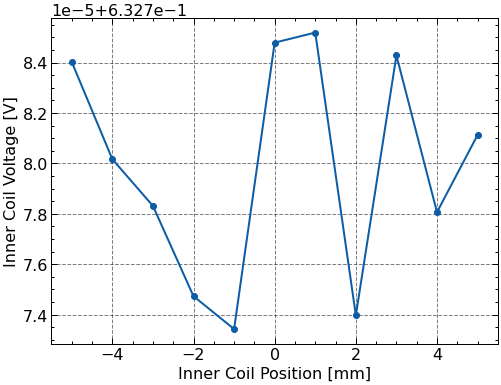

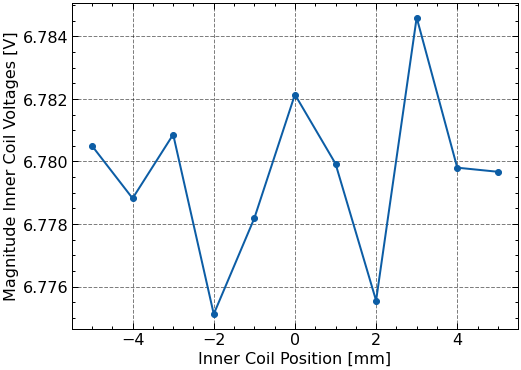

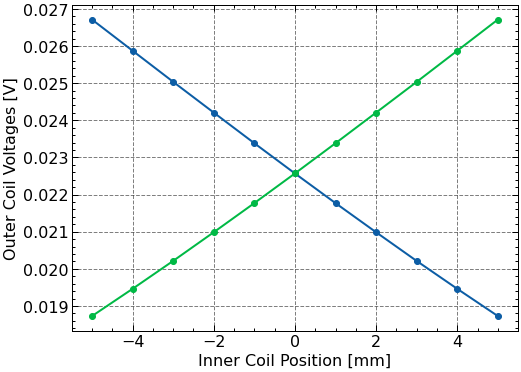

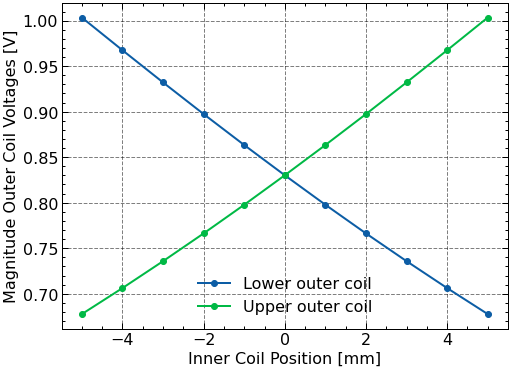

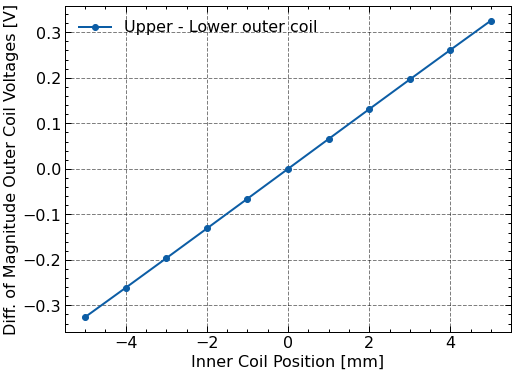

[1.47733624 1.47731359 1.47734209 1.47726316 1.47730581 1.47735881
 1.47732818 1.47726926 1.47739289 1.47732746 1.47732519]
[1.54416931 1.54404861 1.54393276 1.54381559 1.54370797 1.54360423
 1.5435021  1.54340436 1.54332002 1.54323279 1.54315296]
[1.54315407 1.5432315  1.54331738 1.54340403 1.5435012  1.54360419
 1.54370818 1.54381569 1.54393488 1.54404929 1.54416917]
Phase offset: -0.0668330741030827 -0.06684397697778666


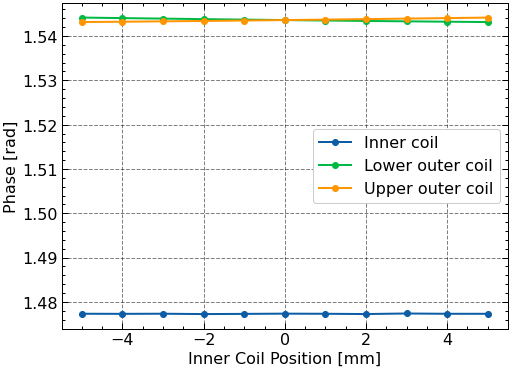

In [19]:
plt.style.use(['science','grid','notebook'])

plt.plot(InnCoil_Positions, InnCoil_Voltages.real,'o-')
plt.ylabel('Inner Coil Voltage [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, abs(InnCoil_Voltages),'o-')
plt.ylabel('Magnitude Inner Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, LowOutCoil_Voltages.real, 'o-',label="Lower outer coil")
plt.plot(InnCoil_Positions, UppOutCoil_Voltages.real,'o-', label="Upper outer coil")
plt.ylabel('Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, abs(LowOutCoil_Voltages),'o-', label="Lower outer coil",)
plt.plot(InnCoil_Positions, abs(UppOutCoil_Voltages),'o-', label="Upper outer coil",)
plt.ylabel('Magnitude Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
plt.show()

plt.plot(InnCoil_Positions, abs(UppOutCoil_Voltages) - abs(LowOutCoil_Voltages),'o-', label="Upper - Lower outer coil",)
plt.ylabel('Diff. of Magnitude Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
plt.show()

InnCoil_Phases = np.angle(InnCoil_Voltages)
LowOutCoil_Phases = np.angle(LowOutCoil_Voltages)
UppOutCoil_Phases = np.angle(UppOutCoil_Voltages)
print(InnCoil_Phases)
print(LowOutCoil_Phases)
print(UppOutCoil_Phases)
print("Phase offset:", InnCoil_Phases[0] - LowOutCoil_Phases[0], InnCoil_Phases[NSteps] - UppOutCoil_Phases[NSteps])

plt.plot(InnCoil_Positions, InnCoil_Phases,'o-', label="Inner coil",)
plt.plot(InnCoil_Positions, LowOutCoil_Phases, 'o-',label="Lower outer coil",)
plt.plot(InnCoil_Positions, UppOutCoil_Phases,'o-', label="Upper outer coil",)
plt.ylabel('Phase [rad]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
plt.show()

Fitted slope of the function: 3.2638763036391274
[ 3.2638763e+00 -1.5971360e-05]


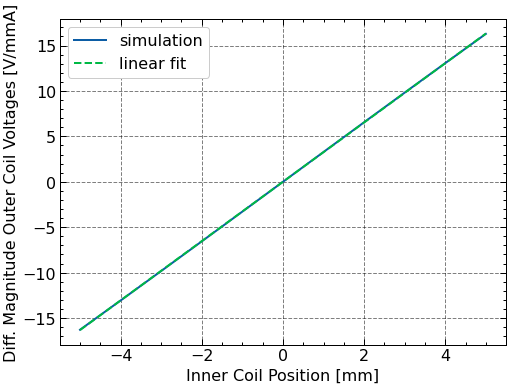

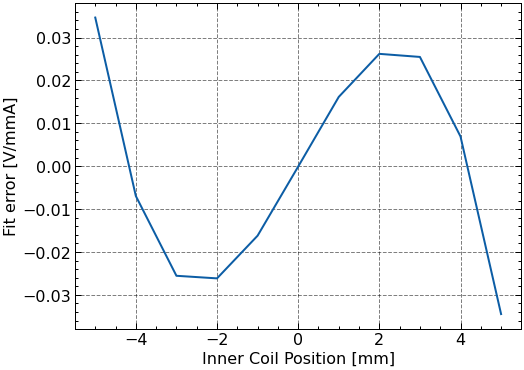

[-1.63193975e+01 -1.30555212e+01 -9.79164488e+00 -6.52776858e+00
 -3.26389227e+00 -1.59713600e-05  3.26386033e+00  6.52773664e+00
  9.79161294e+00  1.30554892e+01  1.63193655e+01]
[-1.62847300e+01 -1.30624763e+01 -9.81720166e+00 -6.55393020e+00
 -3.28009745e+00 -1.01915958e-04  3.28002356e+00  6.55394042e+00
  9.81709834e+00  1.30624212e+01  1.62848782e+01]


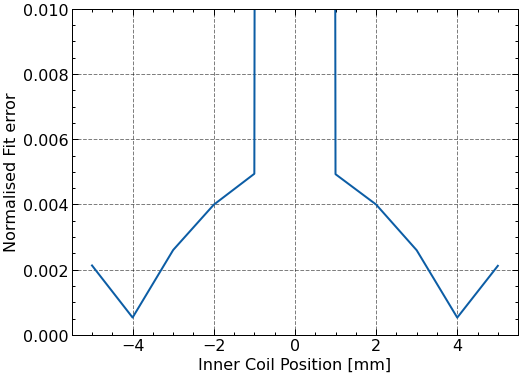

In [20]:
Norm_OutCoil_Signals = (abs(UppOutCoil_Voltages) - abs(LowOutCoil_Voltages))/StepSize/InnCoil_Current

def linfunc(x, a, b):
     return a*x + b
            #ydata: Norm_OutCoil_Signals
            #xdata: InnCoil_Position

optimizedParameters, pcov = opt.curve_fit(linfunc, InnCoil_Positions, Norm_OutCoil_Signals);
print("Fitted slope of the function:",optimizedParameters[0])
fitted_Norm_OutCoil_Signals = linfunc(InnCoil_Positions, *optimizedParameters)
print(optimizedParameters)

plt.plot(InnCoil_Positions, Norm_OutCoil_Signals, label="simulation")
plt.plot(InnCoil_Positions, fitted_Norm_OutCoil_Signals, '--', label="linear fit")
plt.ylabel('Diff. Magnitude Outer Coil Voltages [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
plt.show()

plt.plot(InnCoil_Positions, Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals)
plt.ylabel('Fit error [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

print(fitted_Norm_OutCoil_Signals)
print(Norm_OutCoil_Signals)

plt.plot(InnCoil_Positions, abs(Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals)/abs(Norm_OutCoil_Signals))
plt.ylabel('Normalised Fit error')
plt.xlabel('Inner Coil Position [mm]')
plt.ylim(0.0,0.01)
plt.show()

In [21]:
femm.closefemm()